# Interommatidial synaptic connectivity in the *Megaphragma* lamina

- Quantify the number and types of synaptic connections in the Megaphragma lamina connectome that go between neurons different ommatidia columns 
- Display how the retinotopic flow of information represented by these collateral connections
- Compare what we observed to the interommatidial connectivity of the Drosophila lamina

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from os.path import expanduser

from vis.hex_lattice import hexplot
from vis.fig_tools import linear_cmap, subtype_cm, shortened_st

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

c = subtype_cm()
m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

In [31]:
tp = '210511'
data_path = f"~/Data/{tp}_lamina/{tp}"
cx = pd.read_pickle(data_path + "_cxdf.pickle")
links = pd.read_pickle(data_path + "_linkdf.pickle")

In [32]:
collateral_links = []
home_links = []
om_list = []

# Go through all the links (syn contacts) and find those where pre_om != post_om
for i, l in links.iterrows():
    if (l.post_om != 'UNKNOWN'):
        om_list.append(l.pre_om)
    if (l.pre_om != l.post_om) and (l.post_om != 'UNKNOWN'):
        collateral_links.append(l)
    elif (l.pre_om == l.post_om) and (l.post_om != 'UNKNOWN'):
        home_links.append(l)
    else:
        continue
    
om_list = list(sorted(set(om_list)))
collaterals = pd.DataFrame(collateral_links)
homes = pd.DataFrame(home_links)

display(f"Total contacts: {len(links)}")
display(f"Total identified contacts: {len(homes) + len(collaterals)}")
display(f"% UNKNOWN: {int(sum(links.post_om == 'UNKNOWN'))/int(len(links)) * 100.0}")
display(f"Number of interom contacts: {len(collaterals)}")
display(f"Number of home contacts: {len(homes)}")
display(f"Interom % of total: {float(len(collaterals))/float(len(homes) + len(collaterals))}")

'Total contacts: 20779'

'Total identified contacts: 19536'

'% UNKNOWN: 5.9820010587612495'

'Number of interom contacts: 877'

'Number of home contacts: 18659'

'Interom % of total: 0.04489148239148239'

## L4 and L2 consistently form collateral arbors that receive inputs from neighboring columns



In [33]:
display(f"Number of interom contacts -> L4: {len(collaterals.loc[collaterals['post_type'] == 'LMC_4'])}")

'Number of interom contacts -> L4: 683'

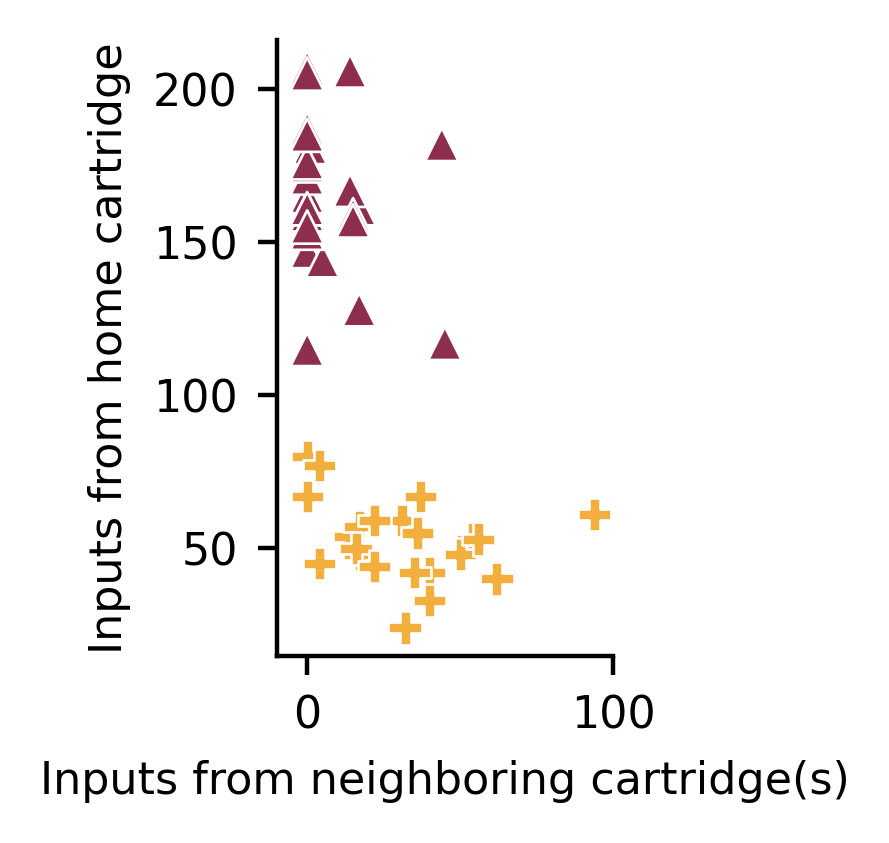

In [34]:
fig, ax = plt.subplots(1, figsize=[2, 2])

summary_data = []

for post_neuron, rows in homes.groupby('post_neuron'):
    post_type = rows.iloc[0].post_type
    if post_type not in ['LMC_2', 'LMC_4']:
        continue
    else:
        if post_neuron not in collaterals['post_neuron'].values:
            inter_inputs = 0
        else:
            inter_inputs = collaterals['post_neuron'].value_counts().loc[post_neuron]
        home_inputs = len(rows)
        inter_home_ratio = inter_inputs/float(len(rows))  # divide by number of rows in home connections 
        summary_data.append({'post_type': post_type, 
                               'post_neuron': post_neuron, 
                               'inter_ratio': inter_home_ratio, 
                               'n_inter': inter_inputs, 
                               'n_home': home_inputs})
        #ax.scatter(x=inter_home_ratio, y=inter_inputs, label=post_type, c=c[post_type], marker=m[post_type])

l2l4_summary = pd.DataFrame(summary_data)
markers = [m[st] for st in l2l4_summary['post_type']]
sns.scatterplot(x='n_inter', y='n_home', hue='post_type', style='post_type', data=l2l4_summary, markers=m, palette=c, ax=ax)


ax.set_xlabel('Inputs from neighboring cartridge(s)')
ax.set_xlim([-10, 225])
ax.set_ylabel('Inputs from home cartridge')
ax.set_xlim([-10, 100])
ax.set_aspect('equal')

ax.get_legend().remove()

[Text(0, 0, 'LMC_2'), Text(1, 0, 'LMC_4')]

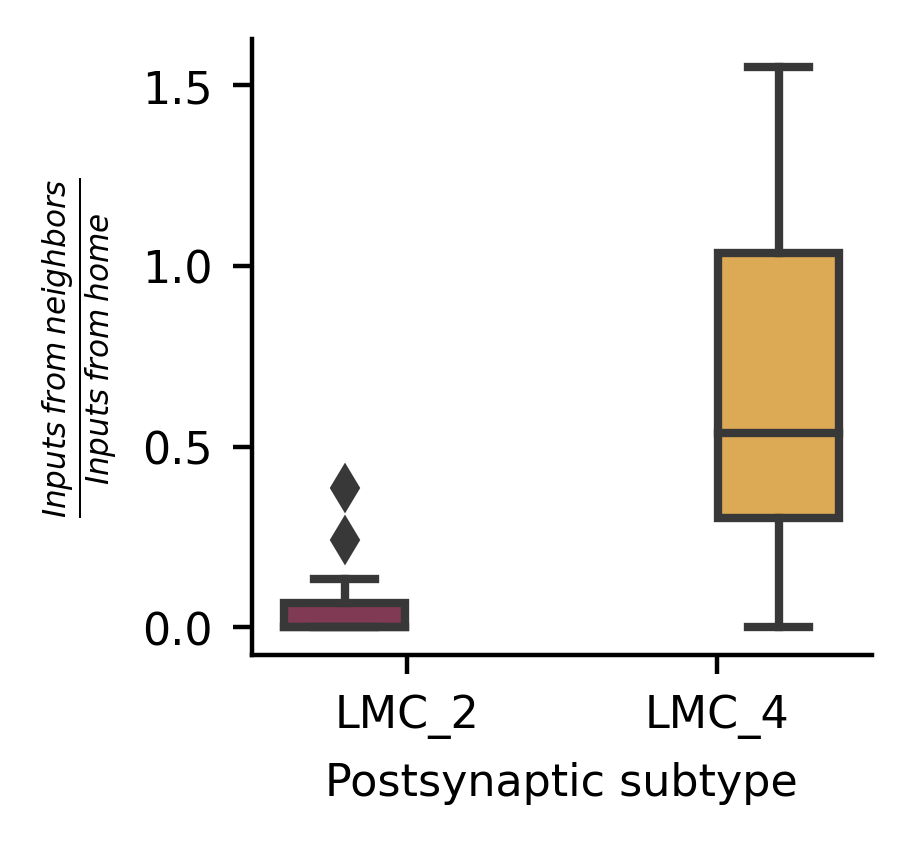

In [35]:
# Boxplot of L2 and L4 inter:home connection ratios calulated above
fig, ax = plt.subplots(1, figsize=[2, 2])


sns.boxplot(x='post_type', y='inter_ratio', hue='post_type', palette=c, data=l2l4_summary, ax=ax)
ax.set_xlabel('Postsynaptic subtype')
#ax.set_xticklabels(['L2', 'L4'])
display(ax.get_xticklabels())

ax.set_ylabel(r'$\frac{Inputs\:from\:neighbors}{Inputs\:from\:home}$')

ax.get_legend().remove()

## Comparing the types of inputs received by L4 from its home and neighboring cartridges

Text(0, 0.5, 'Posterior inputs -> L4')

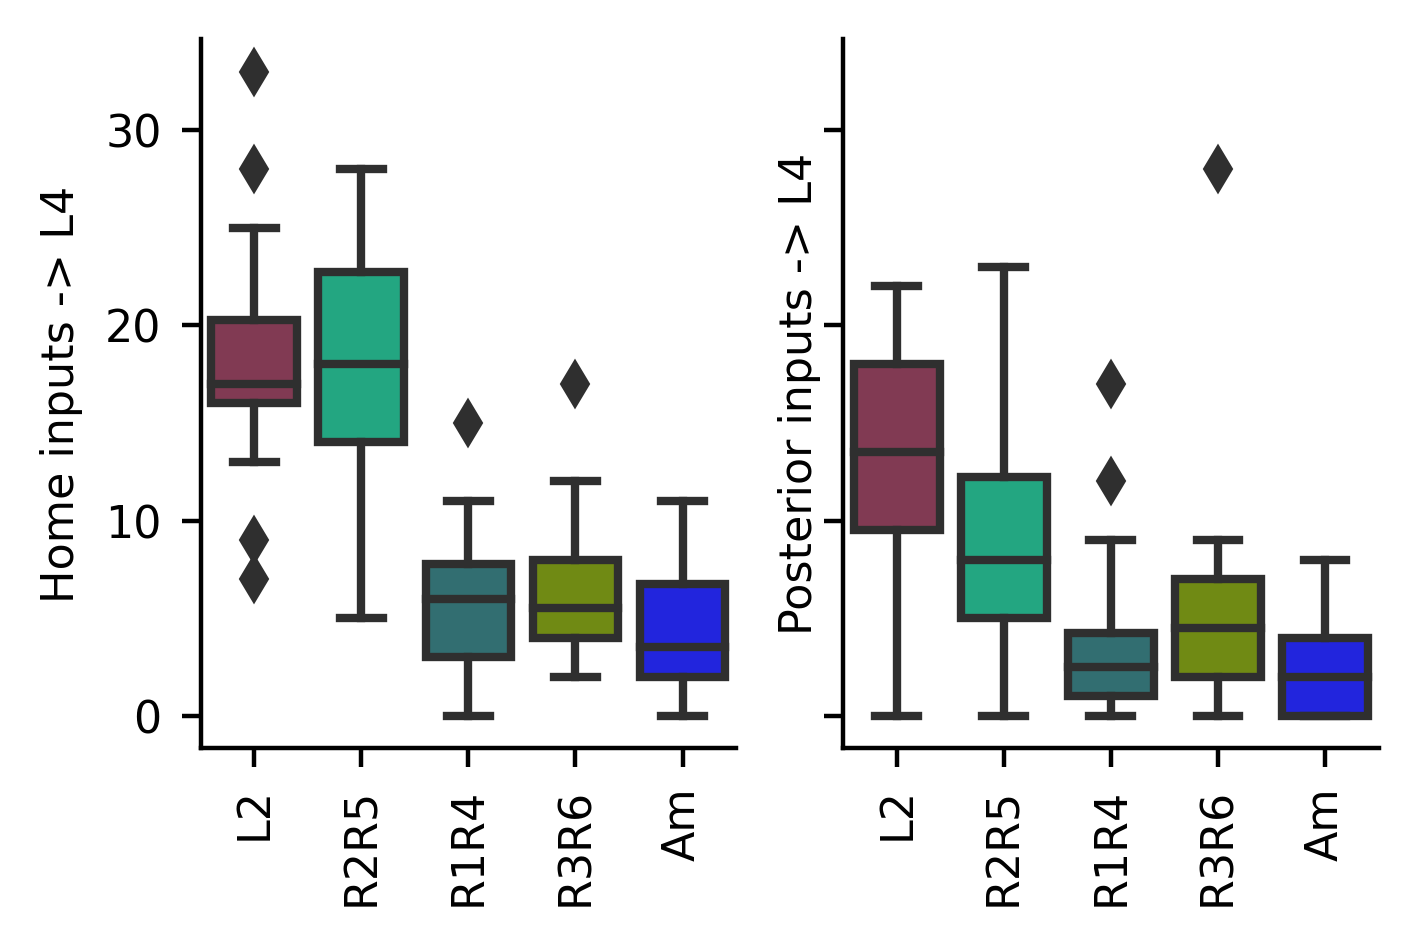

In [36]:
# pre_types = {*homes.loc[homes['post_type'] == 'LMC_4', 'pre_type'].unique(), 
#              *collaterals.loc[collaterals['post_type'] == 'LMC_4', 'pre_type'].unique()}

l4_inter_counts = []
index = []
for pre_neuron, rows in collaterals.loc[collaterals['post_type'] == 'LMC_4'].groupby('post_neuron'):
    index.append(pre_neuron)
    l4_inter_counts.append(rows['pre_type'].value_counts())
l4_inter = pd.DataFrame(l4_inter_counts, index=index).fillna(0).astype(int)

l4_home_counts = []
index = []
for pre_neuron, rows in homes.loc[homes['post_type'] == 'LMC_4'].groupby('post_neuron'):
    index.append(pre_neuron)
    l4_home_counts.append(rows['pre_type'].value_counts())
l4_home = pd.DataFrame(l4_home_counts, index=index).fillna(0).astype(int)

fig, ax = plt.subplots(1, 2, sharey=True)

pre_order = ['LMC_2', 'R2R5', 'R1R4', 'R3R6', 'centri']
sns.boxplot(data=l4_home, order=pre_order, ax=ax[0], palette=c)
sns.boxplot(data=l4_inter, order=pre_order, ax=ax[1], palette=c)
ax[0].set_xticklabels(shortened_st(pre_order), rotation=90)
ax[1].set_xticklabels(shortened_st(pre_order), rotation=90)

ax[0].set_ylabel('Home inputs -> L4')
ax[1].set_ylabel('Posterior inputs -> L4')



In [37]:
# for post_type, rows in collaterals.groupby('post_type'):
#     if len(rows) < 5:  # exclude post synaptic subtypes that received fewer than 5 (total across cartridges)
#         continue  
#     else:

#         display(f"______ {post_type} _______")
#         display(f"Number of cells receive inputs from outside column: {rows['post_neuron'].nunique()}")
#         display(f"Number of inputs from outside column: {len(rows)}")
#         display(f"~~ {post_type} receives these many interommatidial inputs from the following pre-types: ~~~")
#         display(rows['pre_type'].value_counts())
#         display(f"~~ Number of inputs from the following ommatidia ~~~")
#         display(rows['pre_om'].value_counts())
#         print('\n')

In [42]:
data = []

l4_co = collaterals.loc[collaterals['post_type'] == 'LMC_4']

for post_om, links in l4_co.groupby('post_om'):
    for pre_om, l in links.groupby('pre_om'):
#         display(f"{pre_om} to {post_om}")
#         display(f"Number of contacts: {len(l)}")
#         display(f"Line width: {len(l)}")
        data.append({"pre_om": pre_om,
                     "post_om": post_om, 
                     "n_contacts": len(l)})
l4_inter_counts = pd.DataFrame(data, columns=['pre_om', 'post_om', 'n_contacts'])
# l4_inter_counts['line_width'] = ((l4_inter_counts['n_contacts']/l4_inter_counts['n_contacts'].max()) * 3) + 2
# l4_inter_counts['line_width'] = l4_inter_counts['line_width'].round(decimals=1)

# 3 bins (line widths = 2.0, 4.0, 6.0)
l4_inter_counts['line_width'] = np.ceil(l4_inter_counts['n_contacts'] / 30.0) * 2.0
display(l4_inter_counts.iloc[:, [1, 0, 2, 3]])

,post_om,pre_om,n_contacts,line_width
0,A0,B0,88,6.0
1,A0,B1,6,2.0
2,A2,B2,4,2.0
3,A3,B3,14,2.0
4,A5,B5,17,2.0
5,B1,B0,17,2.0
6,B2,C2,31,4.0
7,B2,D3,23,2.0
8,B3,C3,37,4.0
9,B4,C4,31,4.0


In [9]:
to_l4 = dict.fromkeys(om_list, 0)
to_l2 = dict.fromkeys(om_list, 0)
to_all = dict.fromkeys(om_list, 0)

weirdos = []

for i, c in collaterals.iterrows():
        om = c.post_om
        to_all[om] += 1
        if c.post_type == 'LMC_2':
            to_l2[om] += 1
        elif c.post_type == 'LMC_4':
            to_l4[om] += 1
        else:
            weirdos.append(c)


In [10]:
weirdos

[link_id         127069
 cx_id           186571
 pre_neuron     omD4_R5
 pre_om              D4
 pre_type          R2R5
 pre_skel        103372
 post_neuron     omD5_C
 post_om             D5
 post_type       centri
 post_skel       145113
 Name: 4467, dtype: object,
 link_id          106393
 cx_id            192569
 pre_neuron       omD5_C
 pre_om               D5
 pre_type         centri
 pre_skel         145113
 post_neuron    omD4_R7p
 post_om              D4
 post_type           R7p
 post_skel        128140
 Name: 7253, dtype: object,
 link_id         106398
 cx_id           192569
 pre_neuron      omD5_C
 pre_om              D5
 pre_type        centri
 pre_skel        145113
 post_neuron    omD4_L1
 post_om             D4
 post_type        LMC_1
 post_skel       111765
 Name: 7254, dtype: object,
 link_id         106403
 cx_id           192569
 pre_neuron      omD5_C
 pre_om              D5
 pre_type        centri
 pre_skel        145113
 post_neuron    omD4_R5
 post_om          

/mnt/home/nchua/src/cx-analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clist = np.array([min_colour, max_colour])


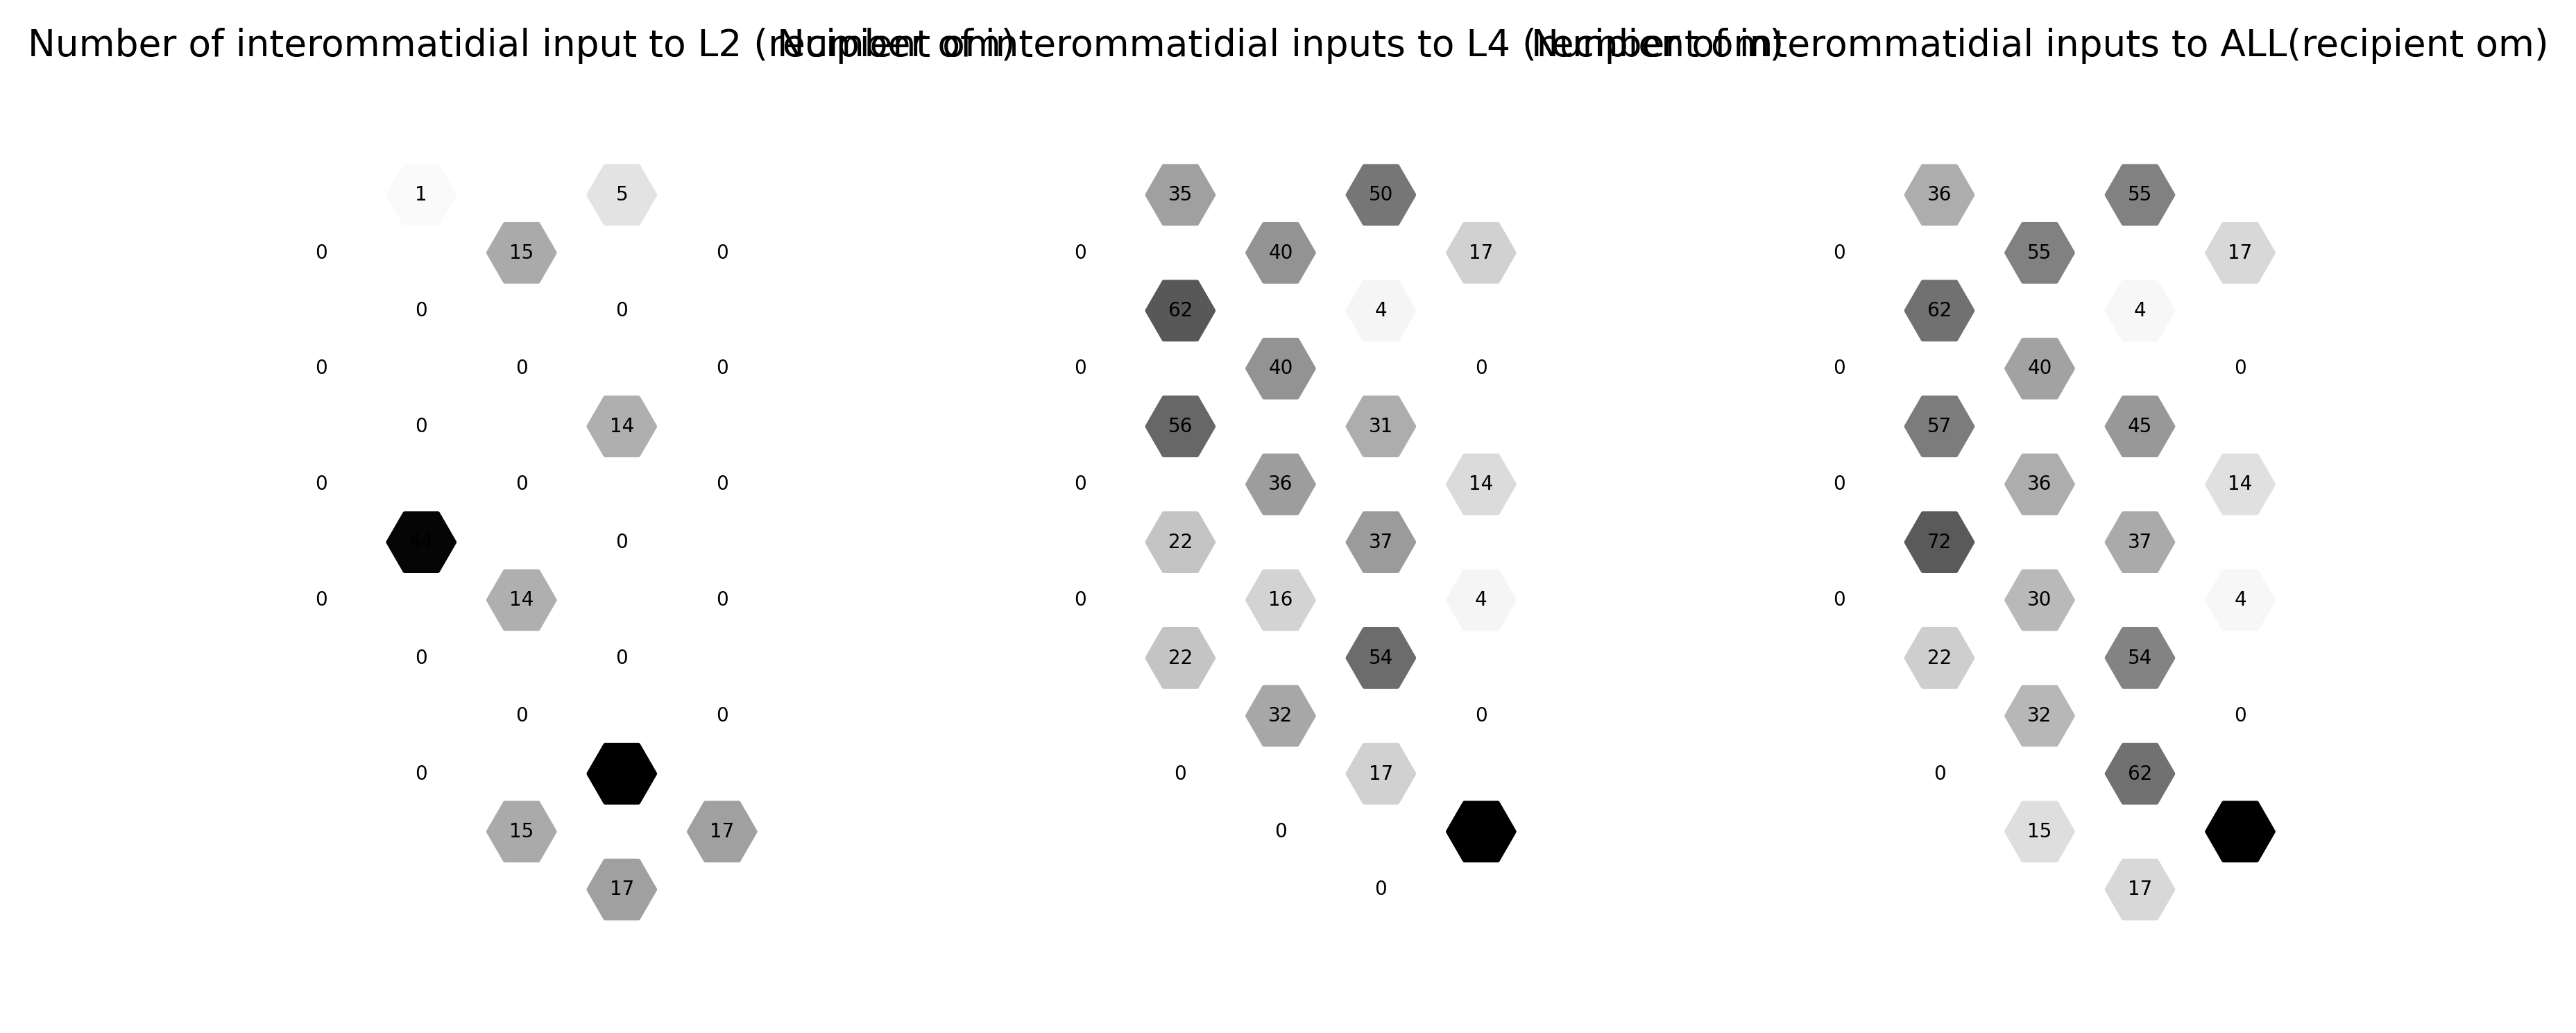

In [11]:
fig, ax = plt.subplots(1, 3, figsize=[10, 5])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/max(to_l2.values())), 
               'label': int(v)} for om, v in to_l2.items()}
l4_dat = {om: {'colour': cm(v/max(to_l4.values())), 
               'label': int(v)} for om, v in to_l4.items()}
all_dat = {om: {'colour': cm(v/max(to_all.values())), 
               'label': int(v)} for om, v in to_all.items()}

hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of interommatidial input to L2 (recipient om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of interommatidial inputs to L4 (recipient om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title('Number of interommatidial inputs to ALL(recipient om)')

plt.show()

In [12]:
out_to_l2 = dict.fromkeys(om_list, 0)
out_to_l4 = dict.fromkeys(om_list, 0)
out_to_all = dict.fromkeys(om_list, 0)
out_weirdos = []

for i, c in collaterals.iterrows():
        om = c.pre_om
        out_to_all[om] += 1
        if c.post_type == 'LMC_2':
            out_to_l2[om] += 1
        elif c.post_type == 'LMC_4':
            out_to_l4[om] += 1
        else:
            out_weirdos.append(c)

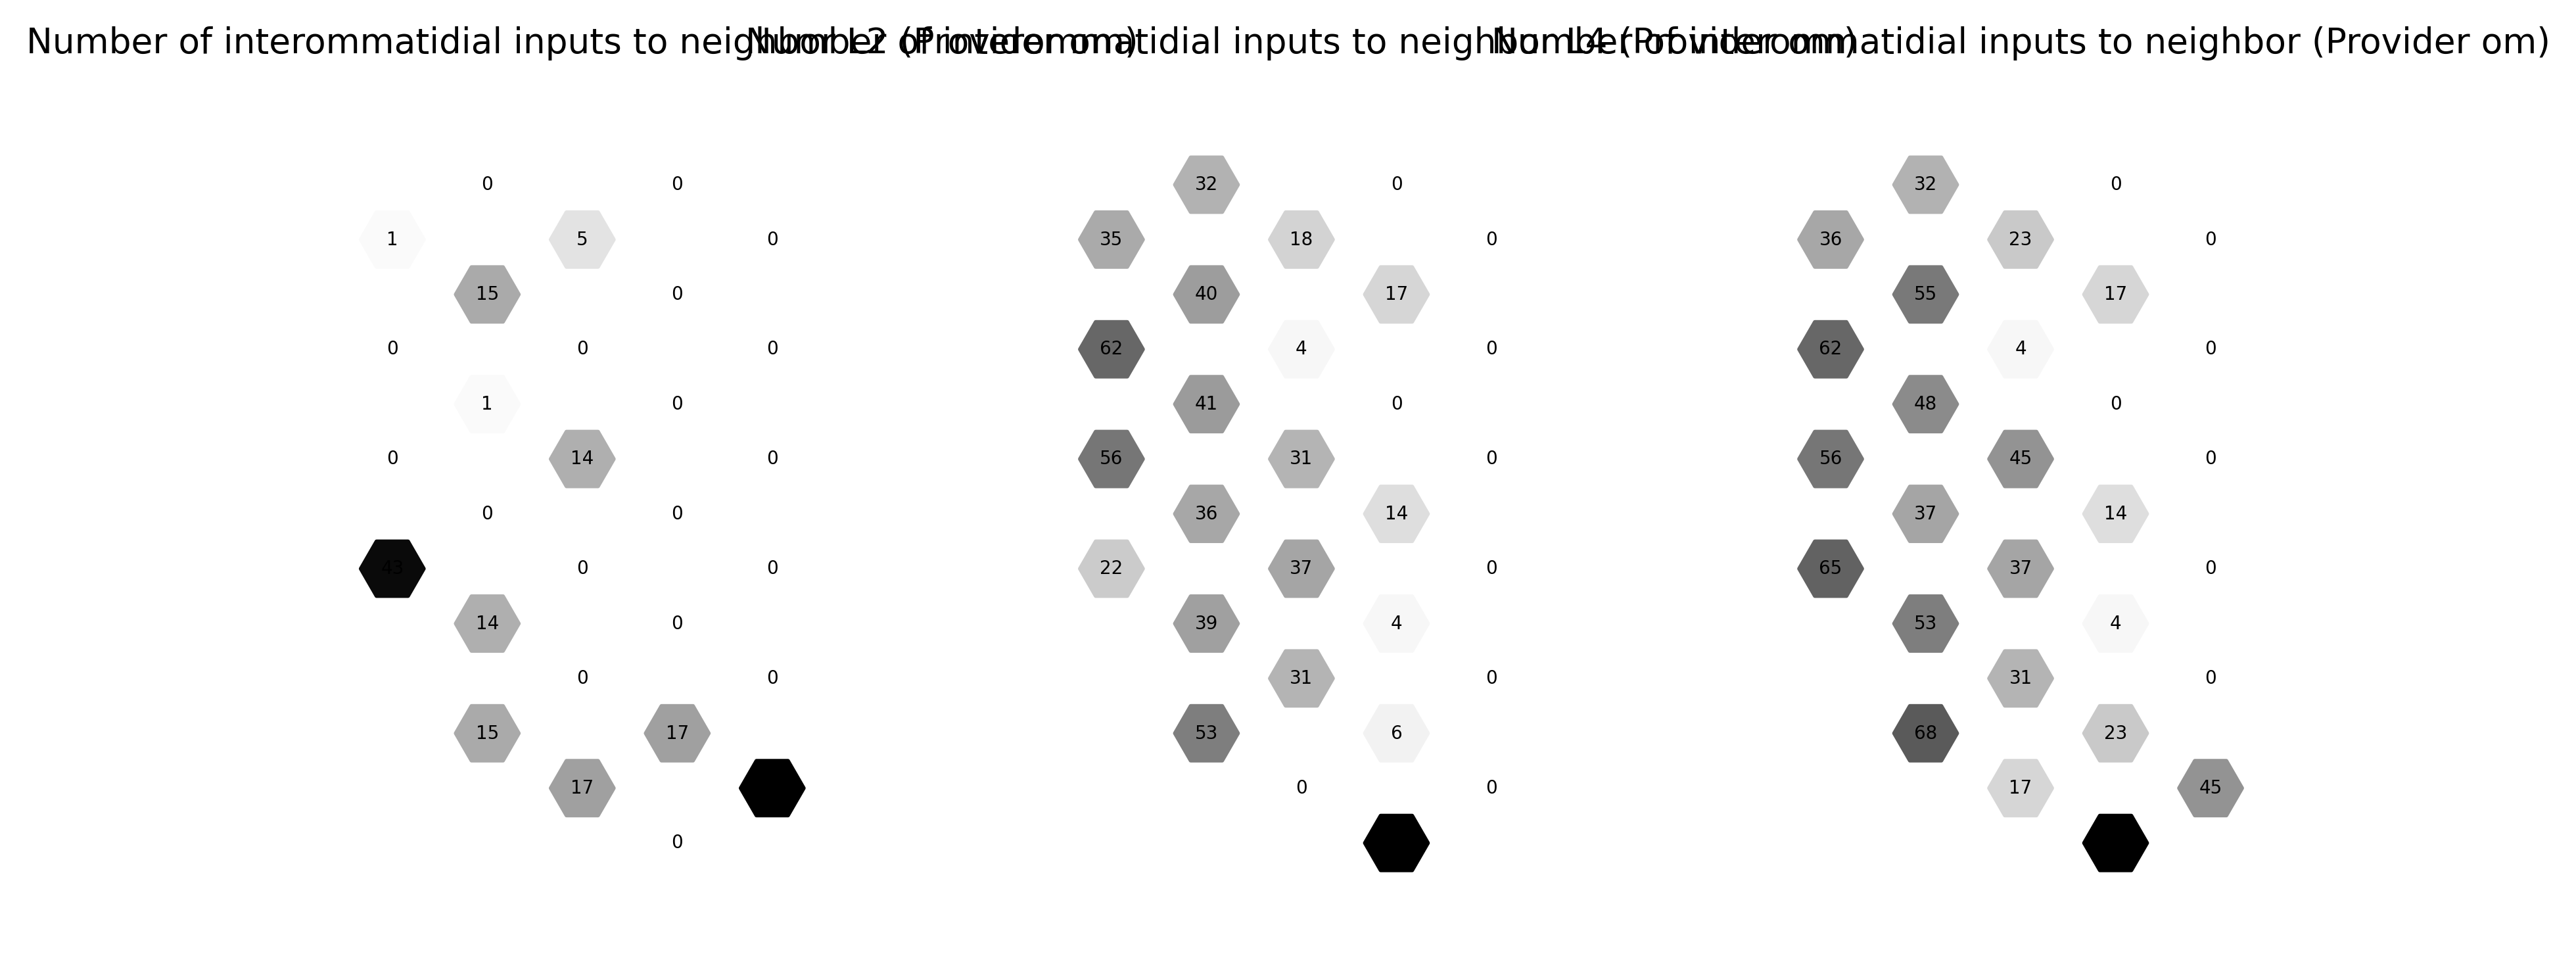

In [13]:
fig, ax = plt.subplots(1, 3, figsize=[10, 5])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/max(out_to_l2.values())), 
               'label': int(v)} for om, v in out_to_l2.items()}
l4_dat = {om: {'colour': cm(v/max(out_to_l4.values())), 
               'label': int(v)} for om, v in out_to_l4.items()}
all_dat = {om: {'colour': cm(v/max(out_to_all.values())), 
                'label': int(v)} for om, v in out_to_all.items()}
hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of interommatidial inputs to neighbor L2 (Provider om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of interommatidial inputs to neighbor L4 (Provider om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title("Number of interommatidial inputs to neighbor (Provider om)")

plt.show()


In [14]:
to_l4_home = dict.fromkeys(om_list, 0)
to_l2_home = dict.fromkeys(om_list, 0)
to_all_home = dict.fromkeys(om_list, 0)

for i, h in homes.iterrows():
        om = h.post_om
        to_all_home[om] += 1
        if c.post_type == 'LMC_2':
            to_l2_home[om] += 1
        elif c.post_type == 'LMC_4':
            to_l4_home[om] += 1
        else:
            continue

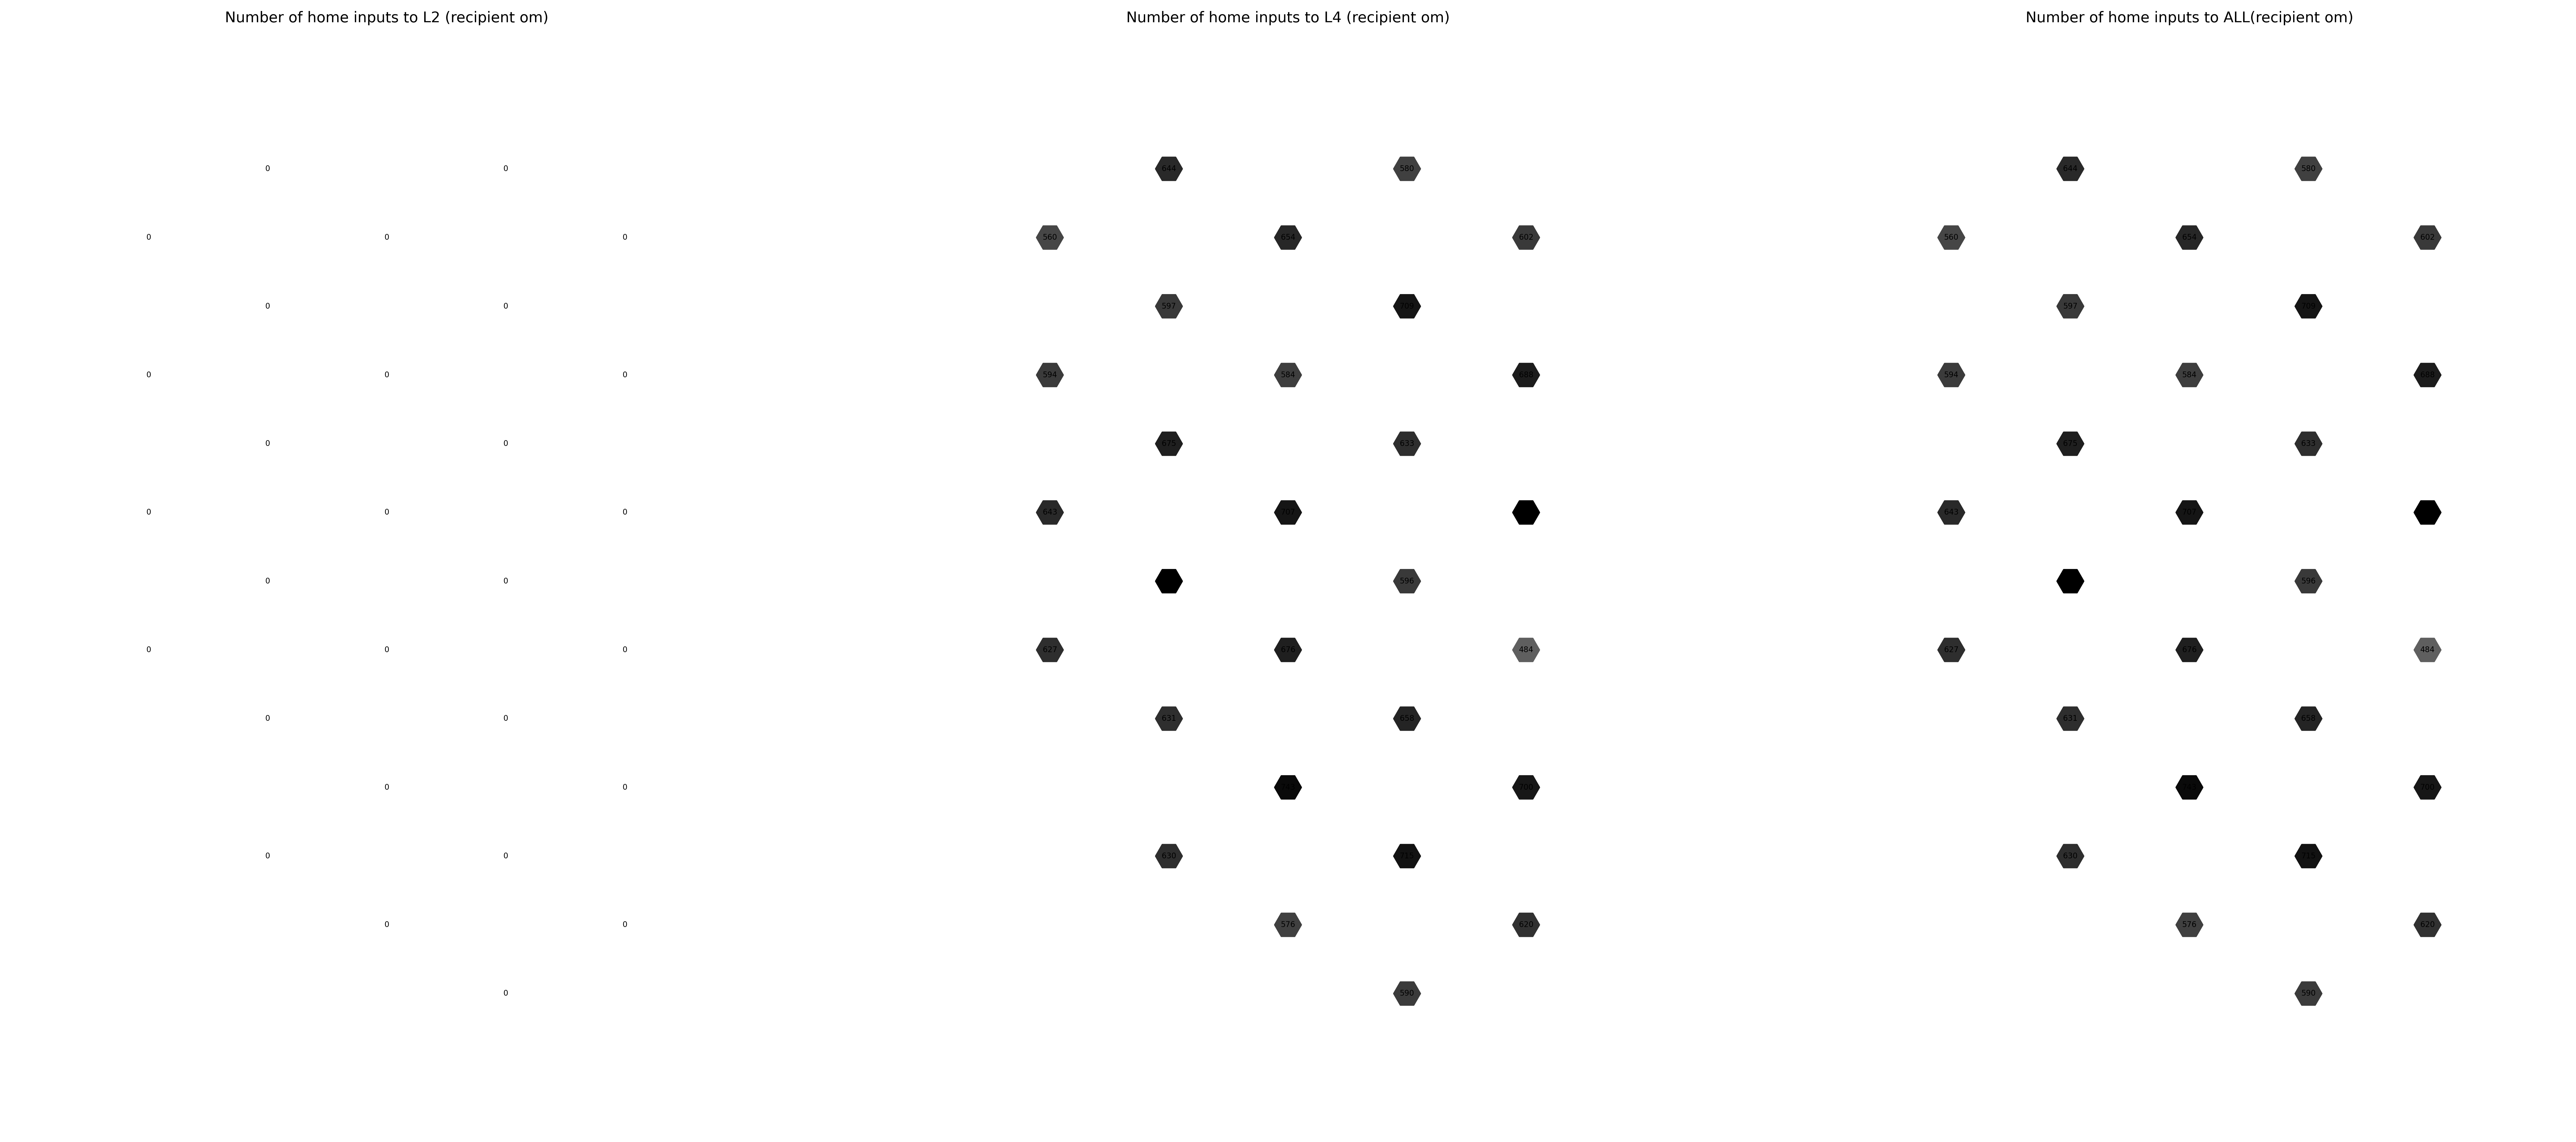

In [15]:
fig, ax = plt.subplots(1, 3, figsize=[30, 15])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/(max(to_l2_home.values()) + 1)), 
               'label': int(v)} for om, v in to_l2_home.items()}
l4_dat = {om: {'colour': cm(v/(max(to_l4_home.values()) + 1)), 
               'label': int(v)} for om, v in to_l4_home.items()}
all_dat = {om: {'colour': cm(v/(max(to_all_home.values()) + 1)), 
               'label': int(v)} for om, v in to_all_home.items()}

hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of home inputs to L2 (recipient om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of home inputs to L4 (recipient om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title('Number of home inputs to ALL(recipient om)')

plt.show()
